# VGG16

In [4]:
!pip install torch

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import json
import numpy as np
from PIL import Image

%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [7]:
vgg16 = models.vgg16(pretrained=True)

NameError: name 'models' is not defined

In [4]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [6]:
!wget https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212105211.png

--2018-04-26 13:52:03--  https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212105211.png
Resolving cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)... 23.194.121.151
Connecting to cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)|23.194.121.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317631 (310K) [image/png]
Saving to: ‘20180212105211.png’

20180212105211.png  100%[===================>] 310.19K  --.-KB/s    in 0.04s   

2018-04-26 13:52:04 (6.84 MB/s) - ‘20180212105211.png’ saved [317631/317631]



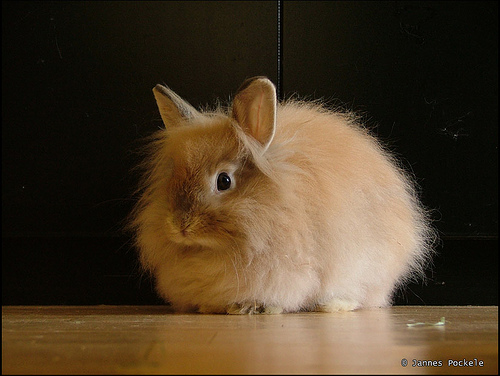

In [7]:
img = Image.open('20180212105211.png')
img

In [8]:
# 4チャンネルだったので最初の3チャンネルを使う
img_tensor = preprocess(img)[:3]
print(img_tensor.shape)

torch.Size([3, 224, 224])


<class 'PIL.Image.Image'>


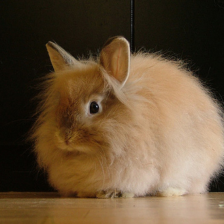

In [9]:
# Tensorにする前なら画像として表示可能
preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])
trans_img = preprocess2(img)
print(type(trans_img))
trans_img

In [10]:
# モデルに入力するときはバッチサイズを入れた4Dテンソルにする必要がある
img_tensor.unsqueeze_(0)
print(img_tensor.size())

torch.Size([1, 3, 224, 224])


In [12]:
out = vgg16(img_tensor)
print(out.size())

torch.Size([1, 1000])


In [20]:
# 出力確率が一番高いインデックスを取得
out.max(dim=1)

(tensor([ 28.5678]), tensor([ 332]))

In [16]:
# 出力確率が高いトップ5のインデックスを取得
out.topk(5)

(tensor([[ 28.5678,  18.9699,  18.1706,  16.8523,  16.8499]]),
 tensor([[ 332,  338,  333,  283,  331]]))

In [21]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2018-04-26 13:55:06--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.67
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.03s   

2018-04-26 13:55:06 (1.31 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [22]:
class_index = json.load(open('imagenet_class_index.json', 'r'))
print(class_index['0'])

['n01440764', 'tench']


In [23]:
labels = {int(key):value for (key, value) in class_index.items()}
print(labels[0])
print(labels[1])

['n01440764', 'tench']
['n01443537', 'goldfish']


In [29]:
index = out.max(dim=1)[1].item()
print(labels[index])

['n02328150', 'Angora']


## 予測を関数化する

In [0]:
def predict(image_file):
    img = Image.open(image_file)
    img_tensor = preprocess(img)[:3]
    img_tensor.unsqueeze_(0)

    with torch.no_grad():
        out = vgg16(img_tensor)

        # 出力を確率にする（分類するだけなら不要）
        out = nn.functional.softmax(out, dim=1)

    maxprob, maxid = out.max(dim=1)
    maxprob, maxid = maxprob.item(), maxid.item()
    label = labels[maxid]
    return img, label, maxprob

['n02328150', 'Angora'] 0.9998789429664612


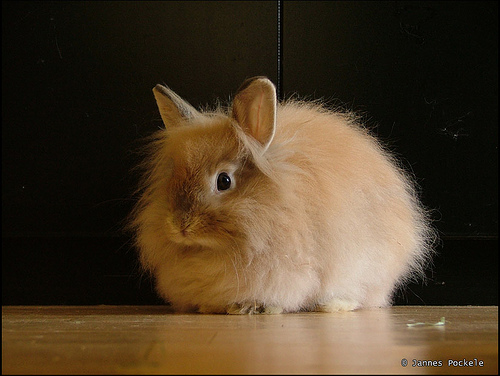

In [37]:
img, label, prob = predict('20180212105211.png')
print(label, prob)
img

In [38]:
!wget https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212112100.png
!wget https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212112141.png

--2018-04-26 14:01:03--  https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212112100.png
Resolving cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)... 23.36.68.182
Connecting to cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)|23.36.68.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96877 (95K) [image/png]
Saving to: ‘20180212112100.png’

20180212112100.png  100%[===================>]  94.61K  --.-KB/s    in 0.03s   

2018-04-26 14:01:04 (2.73 MB/s) - ‘20180212112100.png’ saved [96877/96877]

--2018-04-26 14:01:05--  https://cdn-ak.f.st-hatena.com/images/fotolife/a/aidiary/20180212/20180212112141.png
Resolving cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)... 23.36.68.182
Connecting to cdn-ak.f.st-hatena.com (cdn-ak.f.st-hatena.com)|23.36.68.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386942 (378K) [image/png]
Saving to: ‘20180212112141.png’

20180212112141.png  100%[===================>] 377.87K  --.-K

['n04147183', 'schooner'] 0.9427291750907898


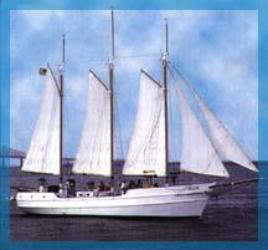

In [39]:
img, label, prob = predict('20180212112100.png')
print(label, prob)
img

['n02699494', 'altar'] 0.8234037160873413


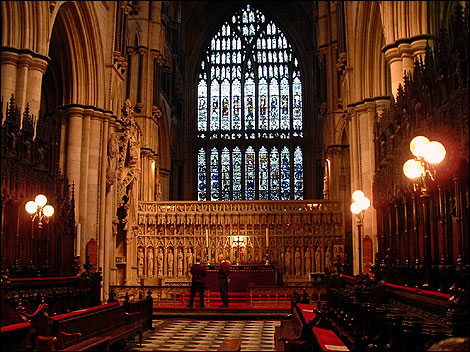

In [40]:
img, label, prob = predict('20180212112141.png')
print(label, prob)
img